In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [14, 6]
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from biosppy.signals import ecg
#
from hrv.classical import time_domain
from hrv.classical import frequency_domain
from hrv.classical import non_linear
from sklearn.preprocessing import MinMaxScaler, StandardScaler
attributes = ['ANN', 'SDNN', 'SDSD', 'NN50', 'pNN50', 'NN20', 'pNN20', 'rMSSD', 'MedianNN']

In [4]:
def timeDomain(NN):
    
    L = len(NN)    
    ANN = np.mean(NN)
    SDNN = np.std(NN)
    SDSD = np.std(np.diff(NN))    
    NN50 = len(np.where(np.diff(NN) > 0.05)[0])    
    pNN50 = NN50/L    
    NN20 = len(np.where(np.diff(NN) > 0.02)[0])
    pNN20 = NN20/L
    rMSSD = np.sqrt((1/L) * sum(np.diff(NN) ** 2))        
    MedianNN = np.median(NN)
    
    timeDomainFeats = {'ANN': ANN, 'SDNN': SDNN,
                       'SDSD': SDSD, 'NN50': NN50,
                       'pNN50': pNN50, 'NN20': NN20,
                       'pNN20': pNN20, 'rMSSD': rMSSD,
                       'MedianNN':MedianNN}
                       
    return timeDomainFeats

In [5]:
def cal_r_peaks(signal, sampling_rate):
    """
    """
    rpeaks, = ecg.hamilton_segmenter(signal=signal,
                                     sampling_rate=sampling_rate)
    rpeaks, = ecg.correct_rpeaks(signal=signal,
                                 rpeaks=rpeaks,
                                 sampling_rate=sampling_rate,
                                 tol=0.05)
    templates, rpeaks = ecg.extract_heartbeats(signal=signal,
                                               rpeaks=rpeaks,
                                               sampling_rate=sampling_rate,
                                               before=0.2,
                                               after=0.4)
    return rpeaks

In [6]:
def create_features(raw_data, fs):
    """
    """
    data  = raw_data[:, :-1]
    label = raw_data[:, -1]

    result = []
    for x in data:
        rpeaks = cal_r_peaks(x, fs)
        tmp = rpeaks[1:] - rpeaks[:-1]
        rri = tmp / fs

        time = timeDomain(rri)
    #     time = time_domain(rri)
        result.append(list(time.values()))
    result = np.array(result)
    return result, label

In [7]:
data_path = '/home/thangnd/git/ecg_201809/data'

training = np.load(data_path + '/training.npy')
testing  = np.load(data_path + '/testing.npy')
evaluate = np.load(data_path + '/test_normal.npy')
print(training.shape)
print(testing.shape)
print(evaluate.shape)

(2161, 10801)
(465, 10801)
(60, 10801)


In [50]:
training_features, training_label = create_features(training, 360)
testing_features, testing_label = create_features(testing, 360)
evaluate_features, evaluate_label = create_features(evaluate, 360)
processed_data = {
    'training_features': training_features,
    'training_label': training_label,
    'testing_features': testing_features,
    'testing_label': testing_label,
    'evaluate_features': evaluate_features,
    'evaluate_label': evaluate_label,
}
np.save(data_path + '/processed_data.npy', processed_data)

In [68]:
processed_data = np.load(data_path + '/processed_data.npy').item(0)

training_features, training_label = processed_data['training_features'], processed_data['training_label']
testing_features, testing_label = processed_data['testing_features'], processed_data['testing_label']
evaluate_features, evaluate_label = processed_data['evaluate_features'], processed_data['evaluate_label']

In [69]:
scaler = StandardScaler()
scaler.fit(training_features)
scaled_training_features = scaler.transform(training_features)
#
scaler.fit(testing_features)
scaled_testing_features = scaler.transform(testing_features)
#
scaler.fit(evaluate_features)
scaled_evaluate_features = scaler.transform(evaluate_features)

In [70]:
index_AF = np.where(testing_label == 1)[0]
index_Normal = np.where(evaluate_label == 0)[0]
AF = scaled_testing_features[index_AF][:len(index_Normal)]
Normal = scaled_evaluate_features[index_Normal]

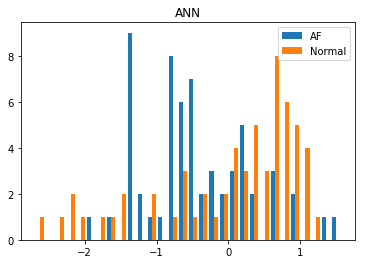

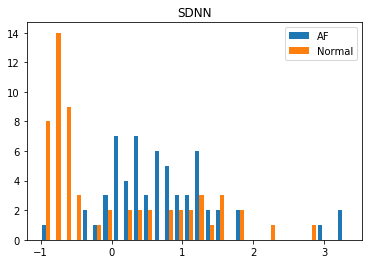

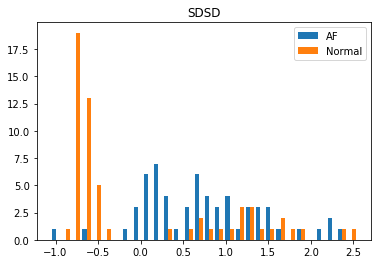

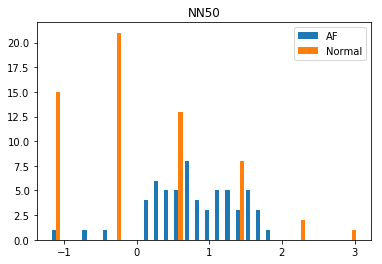

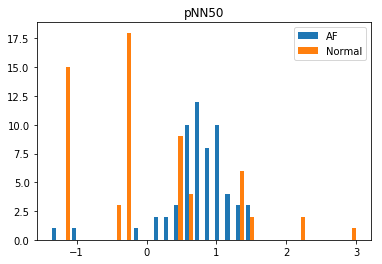

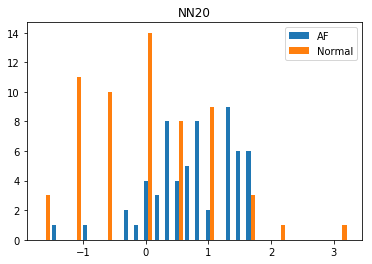

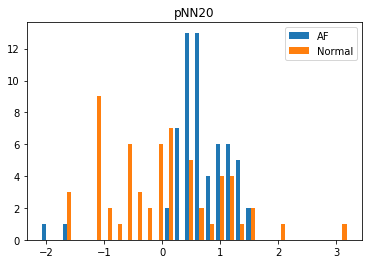

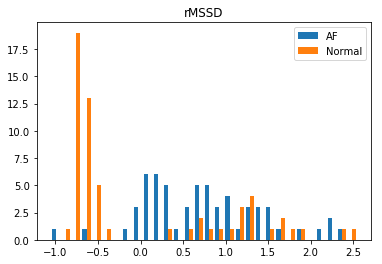

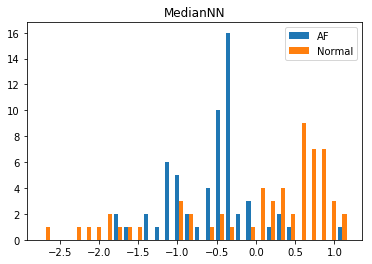

In [71]:
row = 9
#
for r in range(row):
    plt.figure()
    #
    plt.hist([AF[:,r], Normal[:,r]], 30, label=['AF', 'Normal'])
    plt.title(attributes[r])
    plt.legend(loc='upper right')
plt.show()

In [72]:
print(scaled_training_features.shape)
print(scaled_testing_features.shape)
print(scaled_evaluate_features.shape)
evaluate_label

(2161, 9)
(465, 9)
(60, 9)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [73]:
scaled_training_features = np.append(scaled_training_features, scaled_evaluate_features, axis=0)
training_label = np.append(training_label, evaluate_label)
print(scaled_training_features.shape)
print(training_label.shape)
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=((8, 5)), random_state=1)
model.fit(X=scaled_training_features, y=training_label)

(2221, 9)
(2221,)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [80]:
prediction = model.predict(scaled_training_features)
acc = accuracy_score(prediction, training_label)
print(acc)

1.0


In [81]:
prediction = model.predict(scaled_evaluate_features)
acc = accuracy_score(prediction, evaluate_label)
print(acc)

1.0


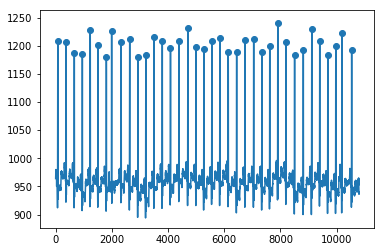

In [34]:
test = evaluate[6][:-1]
rpeaks = cal_r_peaks(test, 360)

plt.figure()
plt.plot(list(range(len(test))), test)
plt.scatter(rpeaks, test[rpeaks])


plt.show()